In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import torch
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR100, CIFAR10
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, TensorDataset

from medmnist import PathMNIST

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

warnings.filterwarnings("ignore")

### Note

All Datasets will be of the format (N, C, H, W) with values between 0 and 1, unless stated otherwise.

This format is easier to deal with in PyTorch.

In [2]:
srmodel = torch.load('model/model_srresnet.pth')["model"]
srmodel = srmodel.cuda()

In [3]:
def generate_sr_dataset(dataset, model):
    sr_images, sr_targets = [], []    
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False, num_workers=4)
    for (inputs, targets) in tqdm(dataloader):
        with torch.no_grad():
            inputs = inputs.cuda()
            inputs = Variable(inputs).float()
            sr_inputs = model(inputs)
            sr_images.append(sr_inputs.cpu().numpy().astype(np.float32))
            sr_targets.append(targets.numpy().astype(np.int64))

    sr_images = np.concatenate(sr_images, axis=0).clip(0, 1)
    sr_targets = np.concatenate(sr_targets, axis=0)

    sr_images = torch.from_numpy(sr_images)
    sr_targets = torch.from_numpy(sr_targets)
    sr_dataset = TensorDataset(sr_images, sr_targets)
    return sr_dataset

In [4]:
# trainset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
# testset = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

trainset = PathMNIST(root='./data', split='train', download=True, transform=transforms.ToTensor())
testset = PathMNIST(root='./data', split='test', download=True, transform=transforms.ToTensor())


Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz


In [5]:
sr_trainset = generate_sr_dataset(trainset, srmodel)
sr_testset = generate_sr_dataset(testset, srmodel)

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
bc_trainset = PathMNIST(root='./data', split='train', download=True, transform=transforms.Compose([
    transforms.Resize((112, 112), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
]))
bc_testset = PathMNIST(root='./data', split='test', download=True, transform=transforms.Compose([
    transforms.Resize((112, 112), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
]))

Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz


In [12]:
sr_trainloader = DataLoader(sr_trainset, batch_size=64, shuffle=False, num_workers=4)
sr_testloader = DataLoader(sr_testset, batch_size=64, shuffle=False, num_workers=4)

bc_trainloader = DataLoader(bc_trainset, batch_size=64, shuffle=False, num_workers=4)
bc_testloader = DataLoader(bc_testset, batch_size=64, shuffle=False, num_workers=4)

torch.Size([64, 3, 112, 112]) torch.Size([64, 1])


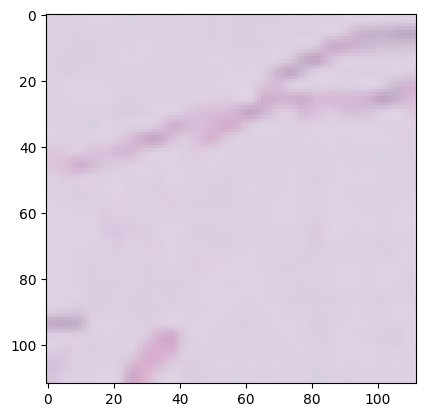

In [13]:
for i, (inputs, targets) in enumerate(bc_trainloader):
    print(inputs.shape, targets.shape)
    plt.imshow(inputs[0].permute(1, 2, 0))
    plt.show()
    break

torch.Size([64, 3, 112, 112]) torch.Size([64, 1])


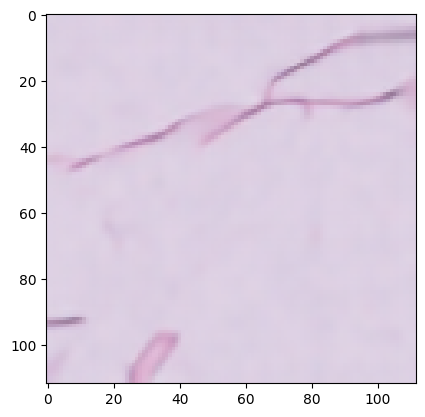

In [14]:
for i, (inputs, targets) in enumerate(sr_trainloader):
    print(inputs.shape, targets.shape)
    plt.imshow(inputs[0].permute(1, 2, 0))
    plt.show()
    break

### Training a CNN

In [15]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [16]:
def create_model(pretrain=True, out_channels=10):
    model = models.resnet18(pretrained=pretrain)
    model.fc = torch.nn.Linear(512, out_channels)
    model = model.cuda()
    return model


def train(model, trainloader, testloader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    accuracy = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(trainloader):
            inputs = inputs.cuda()
            targets = targets.squeeze().cuda()
            inputs = Variable(inputs).float()
            targets = Variable(targets).long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        correct = 0
        total = 0
        with torch.no_grad():
            for (inputs, targets) in testloader:
                inputs = inputs.cuda()
                targets = targets.squeeze().cuda()
                inputs = Variable(inputs).float()
                targets = Variable(targets).long()
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        print(f'Accuracy of the network on the test images: {(100 * correct / total):.2f} %')
        print('Loss on train set: ', running_loss / len(trainloader))
        accuracy.append(correct / total)
    return accuracy

In [17]:
model = create_model(True, 9)
bc_acc = train(model, bc_trainloader, bc_testloader, epochs=15)

torch.save(model.state_dict(), 'model/model_bc_finetune15_pathmnist.pth')

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on the test images: 87.33 %
Loss on train set:  0.2687842023241855
Accuracy of the network on the test images: 88.40 %
Loss on train set:  0.08732120015849733
Accuracy of the network on the test images: 88.80 %
Loss on train set:  0.03857972982072145
Accuracy of the network on the test images: 88.51 %
Loss on train set:  0.01565848627813126
Accuracy of the network on the test images: 88.68 %
Loss on train set:  0.006736533829261229
Accuracy of the network on the test images: 88.83 %
Loss on train set:  0.0034265568890989783
Accuracy of the network on the test images: 88.90 %
Loss on train set:  0.001949091807640586
Accuracy of the network on the test images: 89.01 %
Loss on train set:  0.0012892613269045055
Accuracy of the network on the test images: 89.08 %
Loss on train set:  0.0009634052970092601
Accuracy of the network on the test images: 89.12 %
Loss on train set:  0.0007645224679239561
Accuracy of the network on the test images: 89.07 %
Loss on train set: 

In [18]:
model = create_model(True, 9)
sr_acc = train(model, sr_trainloader, sr_testloader, epochs=15)

torch.save(model.state_dict(), 'model/model_sr_finetune15_pathmnist.pth')

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on the test images: 89.09 %
Loss on train set:  0.24732721727222268
Accuracy of the network on the test images: 89.74 %
Loss on train set:  0.07953303879260615
Accuracy of the network on the test images: 89.36 %
Loss on train set:  0.034084382056084536
Accuracy of the network on the test images: 89.85 %
Loss on train set:  0.012826187231057664
Accuracy of the network on the test images: 90.10 %
Loss on train set:  0.005318762345571142
Accuracy of the network on the test images: 90.17 %
Loss on train set:  0.0027444578296351514
Accuracy of the network on the test images: 90.35 %
Loss on train set:  0.0017108506394391178
Accuracy of the network on the test images: 90.29 %
Loss on train set:  0.001227762170183385
Accuracy of the network on the test images: 90.28 %
Loss on train set:  0.0009511364314352826
Accuracy of the network on the test images: 90.36 %
Loss on train set:  0.00077282537498167
Accuracy of the network on the test images: 90.29 %
Loss on train set:

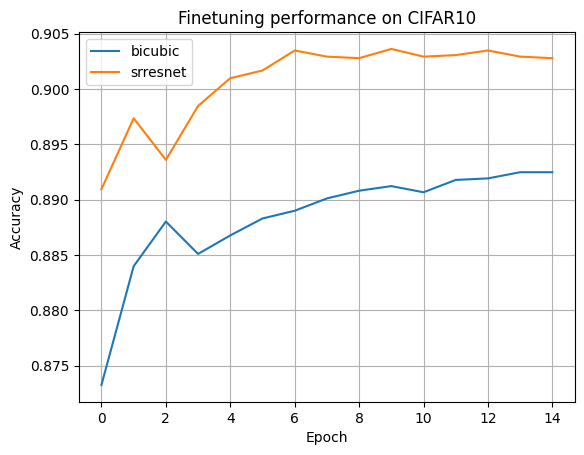

In [19]:
plt.plot(bc_acc, label='bicubic')
plt.plot(sr_acc, label='srresnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Finetuning performance on CIFAR10')
plt.legend()
plt.grid()
plt.show()

In [20]:
model = create_model(False, 9)
bc_acc = train(model, bc_trainloader, bc_testloader, epochs=100)

torch.save(model.state_dict(), 'model/model_bc_scratch100_pathmnist.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the test images: 72.06 %
Loss on train set:  0.7031946867365488
Accuracy of the network on the test images: 76.45 %
Loss on train set:  0.35265462978477585
Accuracy of the network on the test images: 77.16 %
Loss on train set:  0.24851300078096675
Accuracy of the network on the test images: 78.68 %
Loss on train set:  0.18851157373271474
Accuracy of the network on the test images: 78.65 %
Loss on train set:  0.1445983362462909
Accuracy of the network on the test images: 78.20 %
Loss on train set:  0.10817027190043547
Accuracy of the network on the test images: 76.67 %
Loss on train set:  0.07675516807064467
Accuracy of the network on the test images: 76.24 %
Loss on train set:  0.057492345602710965
Accuracy of the network on the test images: 77.51 %
Loss on train set:  0.04517007813962374
Accuracy of the network on the test images: 79.96 %
Loss on train set:  0.0361841539753033
Accuracy of the network on the test images: 80.58 %
Loss on train set:  0.03045082

In [21]:
model = create_model(False, 9)
sr_acc = train(model, sr_trainloader, sr_testloader, epochs=100)

torch.save(model.state_dict(), 'model/model_sr_scratch100_pathmnist.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the test images: 77.63 %
Loss on train set:  0.6644431215253551
Accuracy of the network on the test images: 78.83 %
Loss on train set:  0.320557519989439
Accuracy of the network on the test images: 79.42 %
Loss on train set:  0.21969339699903404
Accuracy of the network on the test images: 80.91 %
Loss on train set:  0.16129347128434837
Accuracy of the network on the test images: 81.18 %
Loss on train set:  0.12115162437981591
Accuracy of the network on the test images: 82.03 %
Loss on train set:  0.08953074204875124
Accuracy of the network on the test images: 82.33 %
Loss on train set:  0.06602581525049368
Accuracy of the network on the test images: 80.67 %
Loss on train set:  0.04811425389627335
Accuracy of the network on the test images: 79.35 %
Loss on train set:  0.03601871323328288
Accuracy of the network on the test images: 79.48 %
Loss on train set:  0.029529692898286
Accuracy of the network on the test images: 81.96 %
Loss on train set:  0.02149284242

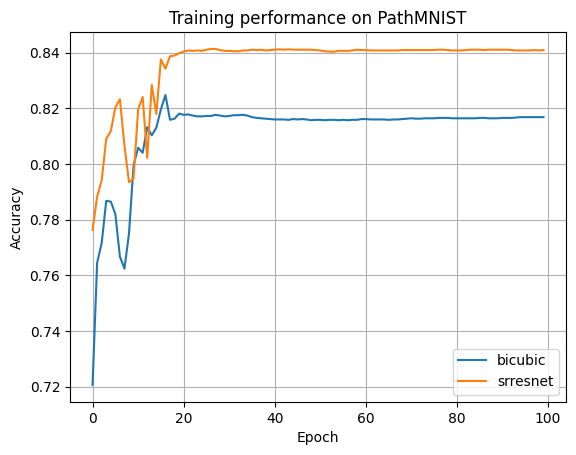

In [23]:
plt.plot(bc_acc, label='bicubic')
plt.plot(sr_acc, label='srresnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training performance on PathMNIST')
plt.legend()
plt.grid()
plt.show()